### Different imports

In [1]:
import numpy as np
import geopandas
import pandas
import shapely.geometry
import matplotlib.pyplot as plt
from osgeo import osr

### Define a function to draw the different graphics below

In [2]:
def graphics(gpdList, title):
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    
    if len(gpdList) == 1:
        gpdList[0].plot(ax=ax)
    elif len(gpdList) == 2:
        gpdList[0].plot(ax=ax)
        gpdList[1].plot(color='r', ax=ax)
    
    plt.suptitle(title, size='xx-large', weight='bold', y=0.95)
    
    ax.set_xlim(400000, 800000)
    ax.xaxis.set_ticks(np.arange(400000, 800001, 100000))
    ax.set_xlabel('Longitude', size='large', weight='bold')
    
    ax.set_ylim(500000, 1000000)
    ax.yaxis.set_ticks(np.arange(500000, 1000001, 100000))
    ax.set_ylabel('Latitude', size='large', weight='bold')
    
    ax.grid(True)
    
    plt.show()

### Ireland map with GADM data

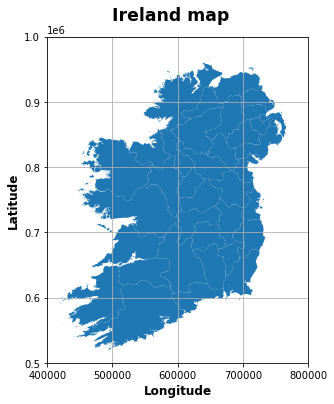

In [3]:
pandasSouth = geopandas.read_file('gadm36_IRL_1.shp')
pandasNorth = geopandas.read_file('gadm36_GBR_2.shp')

pandasSouth = geopandas.GeoDataFrame(pandasSouth, crs='epsg:4326', geometry='geometry')
pandasSouth = pandasSouth.to_crs('epsg:2157')

pandasNorth = geopandas.GeoDataFrame(pandasNorth, crs='epsg:4326', geometry='geometry')
pandasNorth = pandasNorth.to_crs('epsg:2157')

pandasNorth = pandasNorth.query("NAME_1 == 'Northern Ireland'")

pandasIreland = pandas.concat([pandasSouth, pandasNorth], join='inner')

graphics([pandasIreland], 'Ireland map')

### Read Agristats data from shapefile

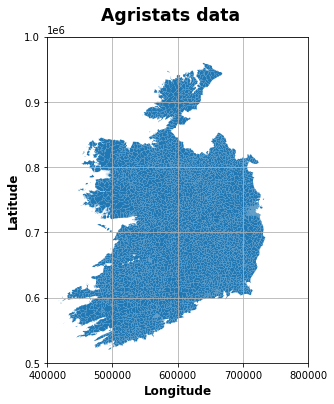

In [4]:
pandasAgristats = geopandas.read_file('HNVf-ED.shp')

# TM65 / Irish Grid, epsg:29902
# IRENET95 / Irish Transverse Mercator, epsg:2157
pandasAgristats = geopandas.GeoDataFrame(pandasAgristats, crs='epsg:29902', geometry='geometry')
pandasAgristats = pandasAgristats.to_crs('epsg:2157')

graphics([pandasAgristats], 'Agristats data')

### Read quadrats data from shapefile

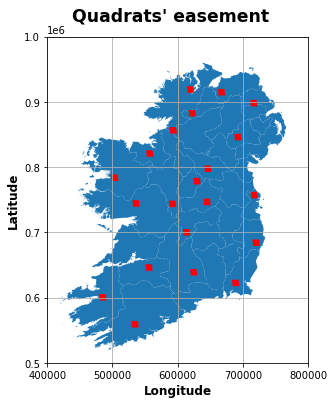

In [5]:
pandasQuadrats = geopandas.read_file('agriclimate_quadrats_Ireland.shp')

prj_file = open('agriclimate_quadrats_Ireland.prj', 'r')
prj_txt = prj_file.read()

srs = osr.SpatialReference()
srs.ImportFromESRI([prj_txt])

proj4Value = srs.ExportToProj4()

# IRENET95 / Irish Transverse Mercator, epsg:2157
pandasQuadrats = geopandas.GeoDataFrame(pandasQuadrats, crs=proj4Value, geometry='geometry')
pandasQuadrats = pandasQuadrats.to_crs('epsg:2157')

graphics([pandasIreland, pandasQuadrats], "Quadrats' easement")

### Filtering Agristats data to just keep values on quadrats

Before filtering, data had 3409 values, and 205 now.


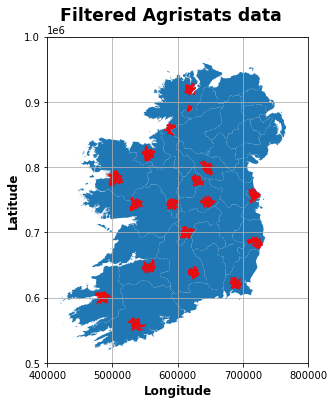

In [6]:
removeIndexes = []

for i in range (len(pandasAgristats.geometry)):
    polyAgristats = pandasAgristats.geometry[i]
    
    if any(polyAgristats.intersects(polyQuadrats) for polyQuadrats in pandasQuadrats.geometry):
        continue
    else:
        removeIndexes.append(i)

pandasFilteredAgristats = pandasAgristats.drop(removeIndexes)

print ("Before filtering, data had {} values, and {} now.".format(len(pandasAgristats), len(pandasFilteredAgristats)))

graphics([pandasIreland, pandasFilteredAgristats], 'Filtered Agristats data')

### Add interesting areas without measurements 

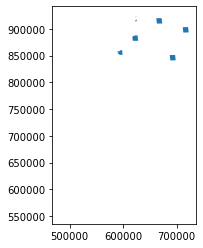

In [7]:
withoutData = []

for polyQ in pandasQuadrats.geometry:
    
    intersect = []
    
    for polyA in pandasFilteredAgristats.geometry:
        if polyA.intersects(polyQ):
            intersect.append(polyA)
    
    diff = polyQ
    for polyI in intersect:
        diff = diff.difference(polyI)
        
    withoutData.append(['NotMeasured', -1, diff])

pandasWithout = pandas.DataFrame(withoutData, columns=['EDNAME', 'HNVf_likel', 'geometry'])

pandasWithout['isEmpty'] = pandasWithout['geometry'].apply(lambda row: row.is_empty)
pandasWithout = pandasWithout.drop(pandasWithout[pandasWithout.isEmpty == True].index.values)
pandasWithout = pandasWithout.drop(['isEmpty'], axis=1)

geoWithout = geopandas.GeoDataFrame(pandasWithout, crs='epsg:2157', geometry='geometry')

geoWithout.plot()

In [8]:
pandasFilteredAgristats = pandas.concat([pandasFilteredAgristats, geoWithout])

print (pandasFilteredAgristats)

               EDNAME  HNVf_likel  \
241  Balbriggan Rural    3.187518   
276      Kilsallaghan    3.210960   
279              Lusk    3.316044   
285       Ballyboghil    3.229751   
286        Balscadden    3.137701   
..                ...         ...   
16        NotMeasured   -1.000000   
17        NotMeasured   -1.000000   
18        NotMeasured   -1.000000   
19        NotMeasured   -1.000000   
20        NotMeasured   -1.000000   

                                              geometry  
241  POLYGON ((718202.761 766363.462, 718354.244 76...  
276  POLYGON ((713184.247 751738.450, 713374.845 75...  
279  POLYGON ((721318.763 751862.282, 721279.051 75...  
285  POLYGON ((713058.664 756203.332, 713075.696 75...  
286  POLYGON ((716530.434 766315.265, 716496.304 76...  
..                                                 ...  
16   MULTIPOLYGON (((480153.268 601808.231, 480153....  
17   POLYGON ((554136.442 641129.854, 554136.442 64...  
18   MULTIPOLYGON (((541406.612 742006.865

#### Save new Agristats data 

In [9]:
pandasFilteredAgristats.to_csv('AgristatsSimplified.txt', index=False, sep=';')